# **Examen 1: Procesamiento de Lenguaje Natural**
# Maestría Ciencias de la Computación UNI


Indicaciones: 
* Desarrolle cada pregunta en el orden correspondiente.
* Pueden utilizar cualquier material ya sea de clase o internet.
* Día de Entrega : Jueves 15 de Junio a las 10pm
* **NO** va haber más tiempo para subir su archivo, considerar los minutos que demora en subir su documento al buzón.
* Subir al buzón el notebook desarrollado en el siguiente formato: nombre_apellido.ipynb
* Evaluación individual, si se detecta **plagio** se **ELIMINARÁ** todos los exámenes involucrados.

# Introducción : 

El objetivo del ejercicio es obtener la **mayor cantidad** de noticias 
de las siguiente fuente.

https://www.facebook.com/prensachalaca

Deberá realizar lo siguiente: (10ptos)

1.   Recuperación de los datos, Dataframe con las siguientes columnas CuerpoNoticia, TipoNoticia , Comentarios
2.   Pre-procesamiento de los comentarios, juntar todos los textos de los comentarios en una columna (prepComentarios) y aplicar pre-procesamiento.
3.   Realizar una nube de palabras con las frecuencias de las palabras en todas las entradas de prepComentarios.
4.   Crear un modelo de lenguaje estadistico usand los comentarios procesados anteriomente.

Luego de obtener el modelo, deberá generar 5 oraciones. (5ptos)

Comentar sus resultados y plantear una hipotesis del porque los resultados podrían variar. (5ptos)

In [ ]:
# Agregar las librerias a utilizar
#....
import unicodedata
#....

In [ ]:
# Para normalizar el texto a unicode utilice lo siguiente
text_normalized= unicodedata.normalize("NFKD", variable_texto_sin_normalizar)

In [ ]:
import requests

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.166 Safari/537.36",
    "Accept-Encoding": "*",
    "Connection": "keep-alive"
}

SESSION = requests.session()
SESSION.cookies.clear()

url = "https://www.facebook.com/prensachalaca/"
print("Requesting URL:", url)
response = requests.get(url, headers=HEADERS)
print("Response code:", response.status_code)

# Desarrollo de Examen

## 1.- Librerías para ingresar a Facebook

La principal librería a usar para lograr el objetivo es : **Selenium**, mediante el uso en modo local con los metodos  **webdriver**, para ello descargamos el driver del navegador google **chromedriver.exe** desde https://chromedriver.chromium.org/home.

Flujo de trabajo :
1. Con el entorno de JupyterLab de Python y librerías de **selenium**, concetarse a Facebook, con credenciales de usuario, password y page (página web a escrapear).
2. Aplicación de rutinas de *scrolling* a la página de facebbok (actualización de barra de desplzaamiento vertical, para la vizualización de post).
3. Extracción de links de post en la versión *web*
4. Transformación de links a la versión *mobile*
5. Ejecutar la extracción de datos de cada uno de los links de versión *mombile* con la librería **BeautifulSoup** y guardarlos en un dataframe.
6. Preprocesamiento de texto para los comentarios y cuerpo de post.
7. Análisis de texto, tokenización y lematización con librerías de **nltk** y **spacy** para la construcción de una nuve de pablas (librería **wordcloud**).
8. Construcción de Modelos Estadisticos N-Gram para los comentarios y cuerpo de post.

In [ ]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import requests
from urllib.request import urlretrieve #pip install resumable-urlretrieve
from selenium.webdriver.common.keys import Keys
from selenium import webdriver
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.action_chains import ActionChains
import time
import os
from tqdm import tqdm_notebook as tqdm
# from tqdm.notebook import trange, tqdm
import timeit

import warnings
warnings.simplefilter("ignore")

In [2]:
cwd = os.getcwd()
cwd

'C:\\Users\\HP\\pyTrainning\\02_Master_UNI\\II Ciclo\\MCC639C - Procesamiento de Lenguaje Natural'

In [3]:
# Funciones para escrapear Facebook
class UtilsFacebookScraper():
    
    def __init__(self):
        print("===================================") 
        print("  Utils Tools to Facebook Scraper  ") 
        print("===================================") 
        
    def login(self, browser, email, password):
        browser.get("https://www.facebook.com/")
        browser.find_element_by_name("email").send_keys(email)
        browser.find_element_by_name("pass").send_keys(password)
        browser.find_element_by_name('login').click()
        time.sleep(5)
    
    def count_needed_scrolls(self, browser, infinite_scroll=False, num_post=None):
        if num_post is None:
            num_post=4
        else:
            num_post=num_post
            
        if infinite_scroll:
            len_page = browser.execute_script("window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")
        else:
            # aproximadamente 4 publicaciones por scroll, ello esta en función a las dimensiones de la página
            len_page = int(num_post/4) 
        print("Number of scrolls needed : " + str(len_page))
        return len_page

    def scroll(self, browser, infinite_scroll=False , len_page=None):
        if len_page is None:
            len_page=4
        else:
            len_page=len_page
        
        last_count = -1
        match = False

        while not match:
            if infinite_scroll:
                last_count = len_page
            else:
                last_count += 1
            # espere a que se cargue el navegador, este tiempo se puede cambiar ligeramente ~ 3 segundos sin diferencia, 
            # pero parece que 5 segundos puede ser lo suficientemente estable.
            time.sleep(5)

            if infinite_scroll:
                len_page = browser.execute_script("window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return "
                    "lenOfPage;")
            else:
                browser.execute_script(
                    "window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return "
                    "lenOfPage;")

            if last_count == len_page:
                match = True

    def extract_link(self,item):
        link_post_acum = []
        i = 1
        while True:
            posts_all = item.find_all("div", attrs={"aria-posinset": str(i)})
            try:
                link_all  = posts_all[0].find_all("a", attrs={"role": "link", "tabindex":"0"})
                link_post = link_all[-1].get('href').replace('web','mobile')

                # link_post_acum.append(link_post)

                if link_post.find('posts')!=-1:
                    link_post_acum.append(link_post)
                else:
                    link_post_acum = link_post_acum

                i = 1+i
            except IndexError:
                break
        return link_post_acum                
                
    def extract_text(self,link):
        link_page   = link
        response = requests.get(link_page)
        html_soup = BeautifulSoup(response.text, 'html.parser')
        main_html_soup = html_soup.find_all("div", { "id" : "m_story_permalink_view"})
        my_text = main_html_soup[0].text  
        return my_text   

    def extract_date(self,link):
        link_page   = link
        response = requests.get(link_page)
        html_soup = BeautifulSoup(response.text, 'html.parser')
        main_html_soup = html_soup.find("abbr")
        my_text = main_html_soup.text
        return my_text

In [4]:
UFS = UtilsFacebookScraper()

  Utils Tools to Facebook Scraper  


In [5]:
help(UFS)

Help on UtilsFacebookScraper in module __main__ object:

class UtilsFacebookScraper(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  count_needed_scrolls(self, browser, infinite_scroll=False, num_post=None)
 |  
 |  extract_date(self, link)
 |  
 |  extract_link(self, item)
 |  
 |  extract_text(self, link)
 |  
 |  login(self, browser, email, password)
 |  
 |  scroll(self, browser, infinite_scroll=False, len_page=None)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



Importar las credenciales para ingreso a la página Facebook

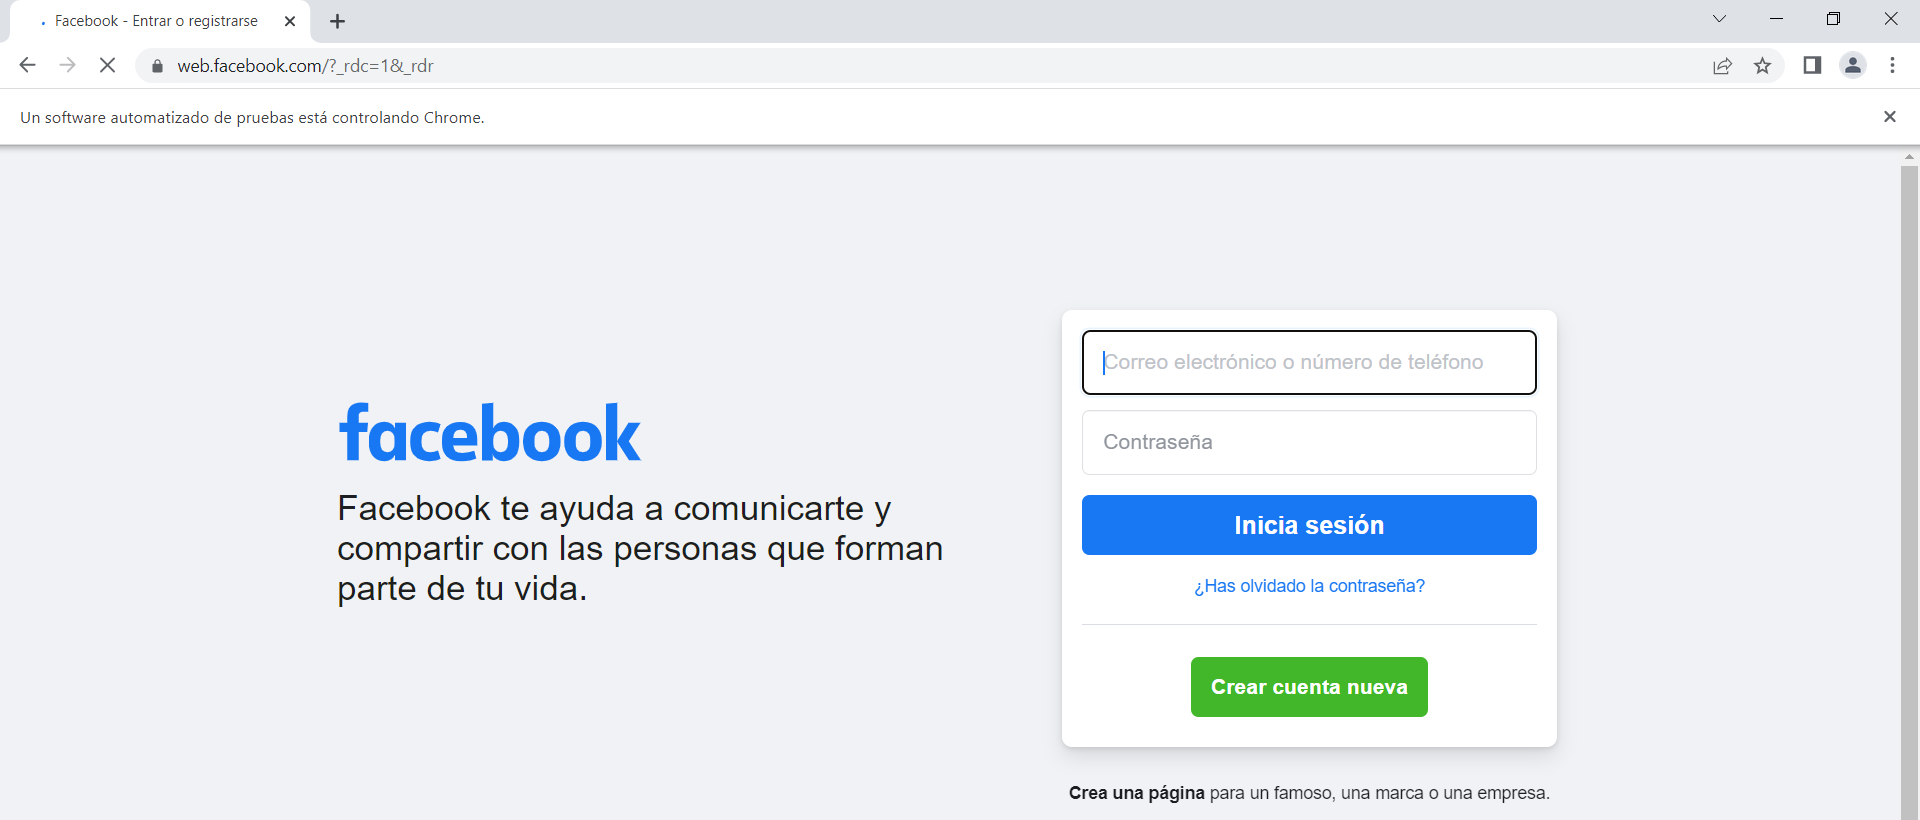

In [6]:
# Importar credenciales desde un archivo txt
with open('credentials.txt') as f:
    email = f.readline().split('"')[1]
    password = f.readline().split('"')[1]
    
# Importar url de página que se desea escrapear desde un archivo txt
with open('input.txt') as f:
    input_page = f.readline().split('"')[0]

In [7]:
input_page

'https://web.facebook.com/prensachalaca'

In [ ]:
# Iniciamos el Selenium
options = Options()
options.add_argument("--disable-notifications")
options.add_argument("--disable-infobars")
options.add_argument("--mute-audio")
options.add_argument("--start-maximized")
browser = webdriver.Chrome(executable_path="./chromedriver", options=options)
UFS.login(browser, email, password)

In [ ]:
# Con las credenciales de ya listos, entremos a un perfil del facebook que se desea escrapear
browser.get(input_page)
time.sleep(5)

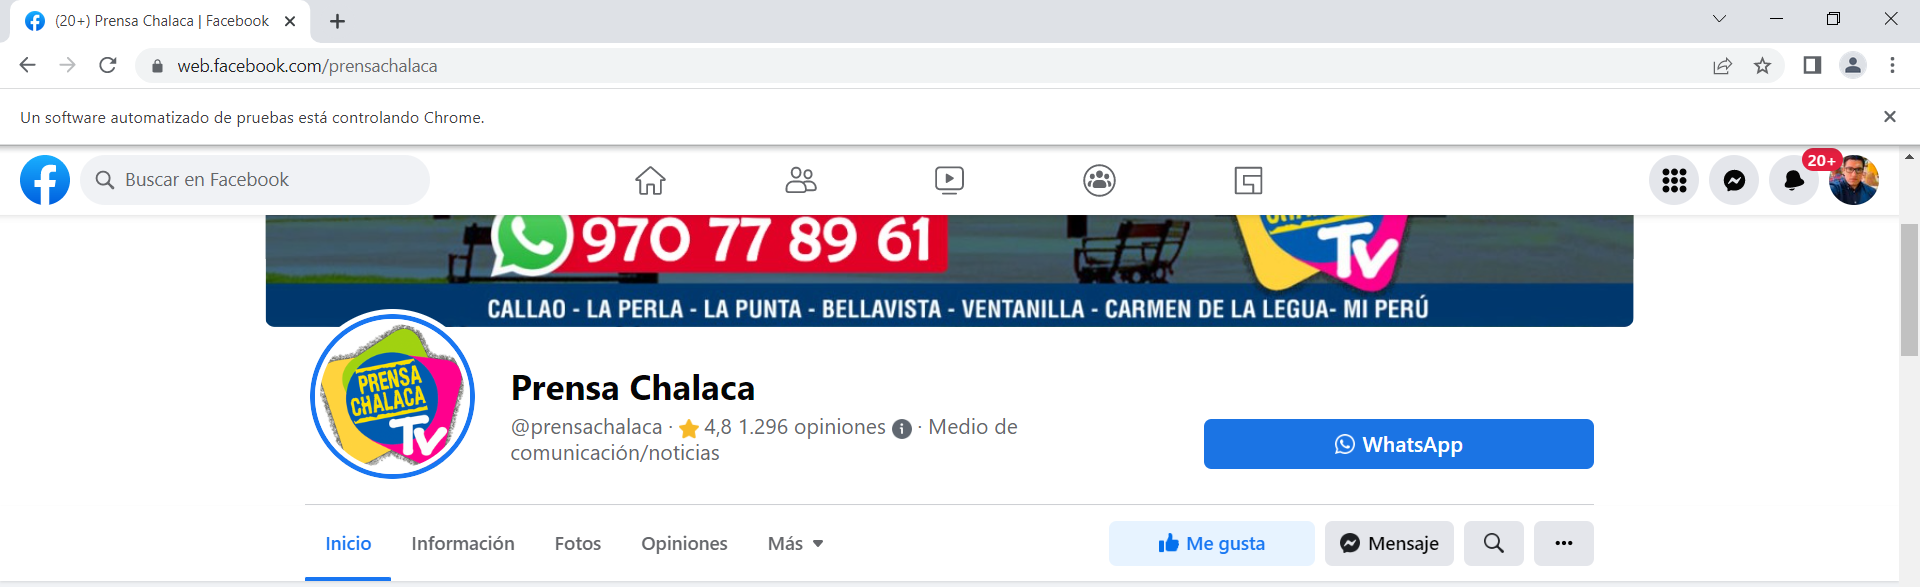

In [ ]:
# Calculamos la cantidad de Publicaciones que se quieren scrapear (Default=4 post por página)
num_post = 200
len_page = UFS.count_needed_scrolls(browser, num_post=num_post)
UFS.scroll(browser, len_page=len_page)

In [ ]:
start = timeit.default_timer()

# Ahora que la página está completamente desplazada (Scrolling), extraemos el código fuente.
source_data = browser.page_source
# Usamos BeautifulSoup inicial
html_soup = BeautifulSoup(source_data, 'html.parser')

end = timeit.default_timer()
print("El tiempo de ejecución es : ", round(end-start,2))

**Nota :** 

Hora y dia de extracción de registro de datos de Facebook : 18 de junio a las 10:06 -->> para trabajos futuros

In [ ]:
# Extraemos los Links de cada uno de los posts, para facilitar el escraping desde facebook modo mobile
links_all = UFS.extract_link(html_soup)

In [ ]:
print("Los Links extraidos son : ", len(links_all))

In [ ]:
# Guardamos el dataframe de los links extraidos, para facilitar el escraping desde facebook modo mobile
df = pd.DataFrame(links_all, columns=['link'])
df.to_csv('links_fb_prensa_chalaca_mobile_2.csv', index=False)

In [ ]:
#  Cerramos la página Web Facebook
browser.close()

In [14]:
# Cargamos los datos de los links extraidos
df_link_all = pd.read_csv('links_fb_prensa_chalaca_mobile.csv')
links_load  = df_link_all.link.tolist()

In [16]:
# Iteramos para la extracción de datos
a_type_news, a_date, a_link, a_body_news, a_comments= [], [], [], [], []
for lks in tqdm(links_load):
    post = UFS.extract_text(lks)
    date = UFS.extract_date(lks)
    all_body = post.split(date)[0]
    comments = post.split(date)[1]

    if all_body.find('|')!=-1:
        type_news = all_body.split('|')[0].replace('Prensa Chalaca','')
        body_news = all_body.split('|')[1]
    else:
        type_news = ''
        body_news = all_body.replace('Prensa Chalaca','')
    
    a_type_news.append(type_news)
    a_date.append(date)
    a_link.append(lks)
    a_body_news.append(body_news)
    a_comments.append(comments)

In [ ]:
fb_scraping = pd.DataFrame(dict(
    type = a_type_news,
    date = a_date,
    body = a_body_news,
    comments  = a_comments,
    link = a_link
    ))

fb_scraping.head()

In [ ]:
# Gradamos el dataframe preliminar en archivo CSV
df = data_facebook
df.to_csv('data_fb_prensa_chalaca_mobile.csv', index=False)

## 2.- Preprocesamiento de Textos

### Carga de datos escrapeados

In [17]:
data_facebook = pd.read_csv('data_fb_prensa_chalaca_mobile.csv')
data_facebook

,type,date,body,comments,link
0,🔴 #BuenaNoticia 🤗,10 h,COMPAÑIA DE BOMBERO RECIBIÓ DONACIONES DE LA ...,· PúblicoMaria Elena Gomez ValleTambién neces...,https://mobile.facebook.com/prensachalaca/post...
1,🔴 #Atención 📣,10 h,"EL CALLAO REGISTRÓ UNA ""NOCHE EXTREMADAMENTE ...",· PúblicoJorge Lozanoprimicia calentita.. en ...,https://mobile.facebook.com/prensachalaca/post...
2,🔴 #LoÚltimo,11 h,MINEDU: UNIVERSIDADES REGRESAN A PRESENCIALID...,· PúblicoKaren T. Palomino RamirezY para los ...,https://mobile.facebook.com/prensachalaca/post...
3,🔴 #LoÚltimo,11 h,CINEPLANET ES CRITICADO POR ADVERTENCIA SOBRE...,· PúblicoHector Alberto Campos ZavalaTotalmen...,https://mobile.facebook.com/prensachalaca/post...
4,NaN,12 h,🔴 MARÍA DEL CARMEN ALVA TRAS DECLARACION DE PE...,· PúblicoJerry Lla EtaSi.. lo mejor es que se...,https://mobile.facebook.com/prensachalaca/post...
...,...,...,...,...,...
177,🔴 #LoÚltimo,4 de junio a las 15:59,CASO SOLSIRET: FISCALÍA APELARÁ PARA QUE ANDR...,· PúblicoJuan Huablocho PerezEstos siniestros...,https://mobile.facebook.com/prensachalaca/post...
178,🔴 #Espectáculos 🔥,4 de junio a las 14:36,SHAKIRA Y GERARD PIQUÉ CONFIRMAN SU SEPARACIÓ...,· PúblicoFiorella PrinqueQue tristeza se veia...,https://mobile.facebook.com/prensachalaca/post...
179,🔴 #LoÚltimo,4 de junio a las 14:15,MONO FUE CAPTURADO Y ENTREGADO A LA POLICÍA E...,· PúblicoGladys Yudi Ramirez CanalesAl pobre ...,https://mobile.facebook.com/prensachalaca/post...
180,NaN,4 de junio a las 11:00,🙏🏼 Gracias Señor mío por cuidar de nuestro sue...,· PúblicoCarmen CamposAMÉN AMÉN AMÉN5 de jun....,https://mobile.facebook.com/prensachalaca/post...


In [18]:
import string
import nltk
import re
import unicodedata
# from spellchecker import SpellChecker

class PreprocessingText():
    def __init__(self):
        print("=====================================") 
        print("  Utils Tools to Preprocessing Text  ") 
        print("=====================================") 
    
    def UpperLowerSplitText(self, text):
        pattP = re.compile(r'(.)([A-Z][a-z]+)')
        pattF = re.compile('([a-z0-9])([A-Z])')
        return pattF.sub(r'\1-\2', pattP.sub(r'\1-\2', text))
    
    def TextOnlyString(self,text):
        string = ''.join([i for i in string if not i.isdigit()])
        string_tuned = ' '.join(re.split(r'\W+', text)).lower().strip(' ')
        return string_tuned
    
    def DeleteEmojify(self,text):
        cat_filter = ["Cn", "Sc", "Sk", "Sm", "So"]  # categorías a filtrar
        return "".join(c for c in text if unicodedata.category(c) not in cat_filter)   
    
    def PreComments(self, comments):
        comments_tuned = comments.replace('· Público','').replace('horas','').replace('hora','').replace('hace','').replace('Hace','')
        comments_tuned = self.UpperLowerSplitText(comments_tuned).replace('-',' ')
        comments_tuned = self.DeleteEmojify(comments_tuned)
        
        table_digits   = str.maketrans('', '', string.digits)
        comments_tuned = comments_tuned.translate(table_digits)
        
        return comments_tuned

In [19]:
PPT = PreprocessingText()

  Utils Tools to Preprocessing Text  


In [20]:
help(PPT)

Help on PreprocessingText in module __main__ object:

class PreprocessingText(builtins.object)
 |  Methods defined here:
 |  
 |  DeleteEmojify(self, text)
 |  
 |  PreComments(self, comments)
 |  
 |  TextOnlyString(self, text)
 |  
 |  UpperLowerSplitText(self, text)
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [21]:
df = data_facebook
df['precomments'] = [PPT.PreComments(comment).strip(' ') for comment in df.comments]
df = df.replace({'type':{np.nan:'#SinTipoNoticia'}})
df['type_tuned'] = [PPT.DeleteEmojify(words).strip(' ') for words in df.type]
df['body_tuned'] = [PPT.DeleteEmojify(body.split('📲 Suscríbete ')[0]).strip(' ') for body in df.body]

### Dataframe Scraping Tuned

In [22]:
dataframe = df[['date','type_tuned','body_tuned','link','precomments']]
dataframe.head()

,date,type_tuned,body_tuned,link,precomments
0,10 h,#BuenaNoticia,COMPAÑIA DE BOMBERO RECIBIÓ DONACIONES DE LA C...,https://mobile.facebook.com/prensachalaca/post...,Maria Elena Gomez Valle También necesitan. ...
1,10 h,#Atención,"EL CALLAO REGISTRÓ UNA ""NOCHE EXTREMADAMENTE F...",https://mobile.facebook.com/prensachalaca/post...,Jorge Lozanoprimicia calentita.. en invierno ...
2,11 h,#LoÚltimo,MINEDU: UNIVERSIDADES REGRESAN A PRESENCIALIDA...,https://mobile.facebook.com/prensachalaca/post...,Karen T. Palomino Ramirez Y para los que tra...
3,11 h,#LoÚltimo,CINEPLANET ES CRITICADO POR ADVERTENCIA SOBRE ...,https://mobile.facebook.com/prensachalaca/post...,Hector Alberto Campos Zavala Totalmente de ...
4,12 h,#SinTipoNoticia,MARÍA DEL CARMEN ALVA TRAS DECLARACION DE PEDR...,https://mobile.facebook.com/prensachalaca/post...,Jerry Lla Eta Si.. lo mejor es que se le inv...


## 3.- Análisis de texto y creación de modelos

### Análisis de comentarios

In [169]:
text_all = ' '.join(dataframe.precomments)

In [170]:
import unicodedata
# para normalizar el texto a unicode utilice lo siguiente, omitir tildes y otros
text_norm = unicodedata.normalize('NFKD', text_all).encode('ascii', 'ignore').decode('ascii')

In [171]:
text_norm[:500]

'Maria  Elena  Gomez  Valle Tambien necesitan.  Sus movilidades.  Que esten ok ..las mangueras que los  senores bomberos n maravillas.   Para tapar lo huecos ...y sus ropas..que usan.  Estan gastados .....muchas veces los senores bomberos salen a vender sus calcomonias.   Para poder subsanar.  Esas  cosas.   Hay mucha gente que los ignoran....senores cuando vean a un senor bombero vendiendo sus rifas. Y sus calcomanias colaboren los ..ellos dan la vida ....en un incendio..... APOYEMOS     Isabel '

In [172]:
#Stop Words de libreria spacy "es_core_news_sm"
from spacy.lang.es.stop_words import STOP_WORDS
stopwords_spacy = list(STOP_WORDS)
# print(stopwords_spacy)
# len(stopwords_spacy)

In [173]:
#Stop Words de libreria nltk
import nltk
from nltk.corpus import stopwords
stop_words_sp = set(stopwords.words('spanish'))
# print(stop_words_sp)
# len(stop_words_sp)

In [174]:
import spacy
nlp = spacy.load("es_core_news_sm")

In [175]:
doc = nlp(text_norm)

In [176]:
# Eliminar los espacios
text_tuned = ' '.join([w.text for w in doc if w.is_space!=True])

In [177]:
text_tuned[:500]

'Maria Elena Gomez Valle Tambien necesitan . Sus movilidades . Que esten ok .. las mangueras que los senores bomberos n maravillas . Para tapar lo huecos ... y sus ropas .. que usan . Estan gastados ..... muchas veces los senores bomberos salen a vender sus calcomonias . Para poder subsanar . Esas cosas . Hay mucha gente que los ignoran .... senores cuando vean a un senor bombero vendiendo sus rifas . Y sus calcomanias colaboren los .. ellos dan la vida .... en un incendio ..... APOYEMOS Isabel R'

In [178]:
doc_tuned = nlp(text_tuned)

In [179]:
for orac in doc_tuned[:40].sents:
    print(orac)

Maria Elena Gomez Valle Tambien necesitan .
Sus movilidades .
Que esten ok ..
las mangueras que los senores bomberos n maravillas .
Para tapar lo huecos ... y sus ropas ..
que usan .
Estan gastados .....
muchas veces los senores bomberos salen a vender sus calcomonias .


In [180]:
for token in doc_tuned[:10]:
    if token.is_stop == False:
        print(token)

Maria
Elena
Gomez
Valle
necesitan
.
movilidades
.


In [181]:
for lem in doc_tuned[:10]:
    print(lem.text,'|', lem.lemma_)

Maria | Maria
Elena | Elena
Gomez | Gomez
Valle | Valle
Tambien | Tambien
necesitan | necesitar
. | .
Sus | su
movilidades | movilidad
. | .


In [182]:
for token in doc_tuned[:10]:
    print(token.text,'|', token.pos_)

Maria | PROPN
Elena | PROPN
Gomez | PROPN
Valle | PROPN
Tambien | PROPN
necesitan | VERB
. | PUNCT
Sus | DET
movilidades | NOUN
. | PUNCT


In [183]:
tokens = [w.text.lower() for w in doc_tuned if w.is_stop!=True and w.is_punct!=True and w.pos_!= 'PROPN']
print(tokens[:10])

['necesitan', 'movilidades', 'esten', 'ok', 'mangueras', 'senores', 'bomberos', 'n', 'maravillas', 'tapar']


In [184]:
len(tokens)

14439

In [185]:
tokens_tuned = [w for w in tokens if len(w)>2 and len(w)<18]
drop_words   = ['jun','respuestas','comentarios','viernes','jueves','ayer','anos','editado','respuesta']
tokens_tuned = [w for w in tokens_tuned if not w in drop_words]

len(tokens_tuned)

12303

In [186]:
lemmas = [w.lemma_.lower() for w in doc_tuned if w.is_stop!=True and w.is_punct!=True and w.pos_!= 'PROPN']
print(lemmas[:10])

['necesitar', 'movilidad', 'estar', 'ok', 'manguera', 'senores', 'bombero', 'n', 'maravilla', 'tapar']


In [187]:
len(lemmas)

14439

In [188]:
lemmas_tuned = [w for w in lemmas if len(w)>2 and len(w)<18]
drop_words   = ['respuesta','jun','comentarios','viernes','editado','jueves','ayer','anos','ano','comentario']
lemmas_tuned = [w for w in lemmas_tuned if not w in drop_words]
len(lemmas_tuned)

12299

In [189]:
from nltk import word_tokenize, FreqDist

In [190]:
freq_tokens = FreqDist(tokens_tuned)
freq_tokens.most_common(10)

[('gente', 70),
 ('vida', 54),
 ('gracias', 49),
 ('personas', 48),
 ('mujer', 43),
 ('pais', 43),
 ('pena', 43),
 ('amen', 43),
 ('senor', 41),
 ('padres', 40)]

In [191]:
freq_lemmas = FreqDist(lemmas_tuned)
freq_lemmas.most_common(10)

[('pasar', 97),
 ('gente', 71),
 ('dejar', 71),
 ('ver', 68),
 ('peruano', 64),
 ('persona', 64),
 ('padre', 63),
 ('vida', 59),
 ('ganar', 59),
 ('salir', 53)]

In [192]:
# pip list

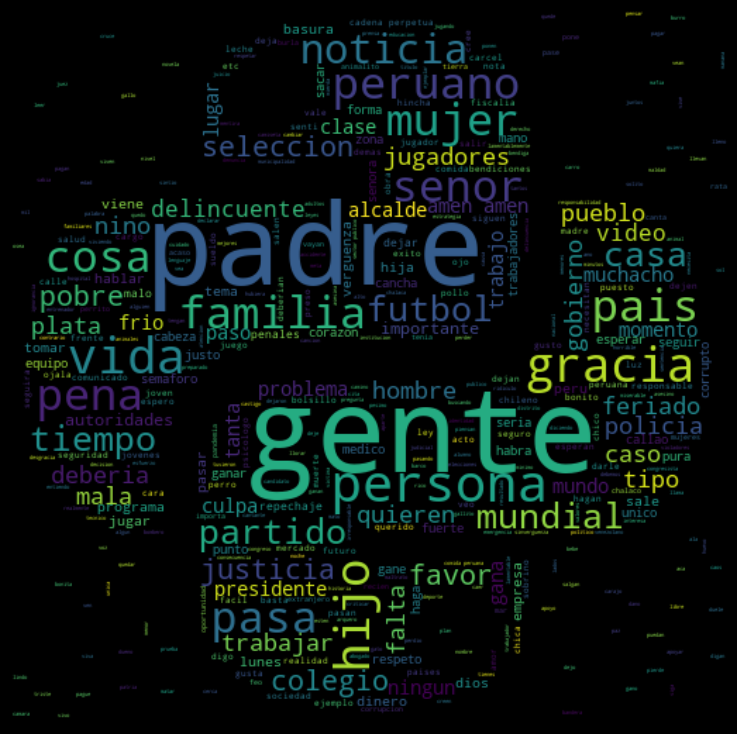

In [193]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

mask = np.array(Image.open("Python.jpg"))
mask[mask == 1] = 255

text = ' '.join(tokens_tuned)
wordcloud = WordCloud(width = 3000,height=2000, max_words=1000, background_color='black', mask=mask).generate(text)
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### Modelo Estadístico N-Gram - Comementarios

In [270]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('reuters')

In [766]:
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams

In [334]:
try: # Use the default NLTK tokenizer.
    from nltk import word_tokenize, sent_tokenize 
    # Testing whether it works. 
    # Sometimes it doesn't work on some machines because of setup issues.
    word_tokenize(sent_tokenize("This is a foobar sentence. Yes it is.")[0])
except: # Use a naive sentence tokenizer and toktok.
    import re
    from nltk.tokenize import ToktokTokenizer
    # See https://stackoverflow.com/a/25736515/610569
    sent_tokenize = lambda x: re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', x)
    # Use the toktok tokenizer that requires no dependencies.
    toktok = ToktokTokenizer()
    word_tokenize = word_tokenize = toktok.tokenize

In [698]:
text_all = ''.join(dataframe.precomments)

In [700]:
# text_all

In [739]:
import unicodedata
# para normalizar el texto a unicode utilice lo siguiente, omitir tildes y otros
text_norm = unicodedata.normalize('NFKD', text_all).encode('ascii', 'ignore').decode('ascii').lower()

bad_chars = ['#', ',','!', '"', ':', '%', '(',')','...',"'",'http','?','jun']

for i in bad_chars :
    text_norm = text_norm.replace(i, '')
    text_norm = text_norm.replace('qe', 'que')

In [740]:
print(text_norm[:282])

maria  elena  gomez  valle tambien necesitan.  sus movilidades.  que esten ok ..las mangueras que los  senores bomberos n maravillas.   para tapar lo huecos y sus ropas..que usan.  estan gastados ..muchas veces los senores bomberos salen a vender sus calcomonias.   para poder subsa


In [741]:
# Tokenize the text.
tokenized_text = [word_tokenize(s.replace('.','')) for s in sent_tokenize(text_norm)]
print(tokenized_text[0])

['maria', 'elena', 'gomez', 'valle', 'tambien', 'necesitan']


In [742]:
freq_tokens = FreqDist(word_tokenize(''.join(([' '.join(s) for s in tokenized_text]))))
freq_tokens.most_common(10)

[('que', 1510),
 ('de', 1356),
 ('a', 1298),
 ('y', 1042),
 ('la', 1026),
 ('las', 911),
 ('no', 831),
 ('el', 822),
 ('en', 685),
 ('los', 574)]

In [744]:
from nltk import bigrams, trigrams
from collections import Counter, defaultdict

# Create a placeholder for model
model = defaultdict(lambda: defaultdict(lambda: 0))

# Count frequency of co-occurance  

sentences = [s.replace('.','') for s in sent_tokenize(text_norm)]
for sentence in sentences:
    for w1, w2, w3 in trigrams(word_tokenize(sentence), pad_right=True, pad_left=True):
        model[(w1, w2)][w3] += 1

for w1_w2 in model:
    total_count = float(sum(model[w1_w2].values()))
    for w3 in model[w1_w2]:
        model[w1_w2][w3] /= total_count

In [745]:
list(trigrams(word_tokenize(sentences[5]), pad_right=True, pad_left=True))

[(None, None, 'para'),
 (None, 'para', 'poder'),
 ('para', 'poder', 'subsanar'),
 ('poder', 'subsanar', None),
 ('subsanar', None, None)]

In [731]:
# dict(model['de','la'])   

In [753]:
import random

for i in range(5):  
    # starting words
    text = ['del', 'peru', 'lo']
    sentence_finished = False
    
    while not sentence_finished:
        # select a random probability threshold  
        r = random.random()
        accumulator = .0
        for word in model[tuple(text[-2:])].keys():
            accumulator += model[tuple(text[-2:])][word]
            # select words that are above the probability threshold
            if accumulator >= r:
                text.append(word)
                break

        if text[-2:] == [None, None]:
            sentence_finished = True
    print('')
    print ('Sentence N° '+str(i+1)+' :\n' +' '.join([t for t in text if t]))


Sentence N° 1 :
del peru lo maximo que podia pasar era un empate eso era supuestamentuque tenias que decir a la familia y si le hubiera ensenado billetes seguro que al final no n nada por mi mediatenorcomediatenorco de

Sentence N° 2 :
del peru lo maximo chicos vamos con todo el peru y de esto tkm hijo jeferson siempre estaras presente en mi callao querido donde esta el callao hay gente honrada y trabajadora que quiere tomar el mando de todas

Sentence N° 3 :
del peru lo maximo chicos vamos con fe otras personas tienen loros que son las mas que diassufren por la maldcion la verdadera es de su casa de

Sentence N° 4 :
del peru lo maximo chicos vamos con todo y de jornada semanal

Sentence N° 5 :
del peru lo maximo que podia pasar era un empate eso era supuestamentuque tenias que decir por sacar plata pobre gallito de


### Análisis de posts

In [306]:
text_all = ' '.join(dataframe.body_tuned)

In [307]:
import unicodedata
# para normalizar el texto a unicode utilice lo siguiente, omitir tildes y otros
text_norm = unicodedata.normalize('NFKD', text_all).encode('ascii', 'ignore').decode('ascii')

In [308]:
text_norm[:500]

'COMPANIA DE BOMBERO RECIBIO DONACIONES DE LA CORTE SUPERIOR DE JUSTICIA DEL CALLAO La Corte Superior de Justicia del Callao dono un total de 30 bienes entre equipos de sonido, accesorios, frazadas, cuadros, lectoras de CD, balon de oxigeno y otros a la Compania de Bomberos Peru-18. Asimismo, la presidenta de la Corte del Callao, Flor Guerrero Roldan senalo que la finalidad es educar, brindar ayuda social y que las instituciones siempre esten coordinando y dandose la mano.  De igual manera, el re'

In [309]:
#Stop Words de libreria spacy "es_core_news_sm"
from spacy.lang.es.stop_words import STOP_WORDS
stopwords_spacy = list(STOP_WORDS)
# print(stopwords_spacy)
# len(stopwords_spacy)

In [310]:
#Stop Words de libreria nltk
import nltk
from nltk.corpus import stopwords
stop_words_sp = set(stopwords.words('spanish'))
# print(stop_words_sp)
# len(stop_words_sp)

In [311]:
import spacy
nlp = spacy.load("es_core_news_sm")

In [312]:
doc = nlp(text_norm)

In [313]:
# Eliminar los espacios
text_tuned = ' '.join([w.text for w in doc if w.is_space!=True])

In [314]:
text_tuned[:500]

'COMPANIA DE BOMBERO RECIBIO DONACIONES DE LA CORTE SUPERIOR DE JUSTICIA DEL CALLAO La Corte Superior de Justicia del Callao dono un total de 30 bienes entre equipos de sonido , accesorios , frazadas , cuadros , lectoras de CD , balon de oxigeno y otros a la Compania de Bomberos Peru-18 . Asimismo , la presidenta de la Corte del Callao , Flor Guerrero Roldan senalo que la finalidad es educar , brindar ayuda social y que las instituciones siempre esten coordinando y dandose la mano . De igual mane'

In [315]:
doc_tuned = nlp(text_tuned)

In [316]:
for orac in doc_tuned[:40].sents:
    print(orac)

COMPANIA DE BOMBERO RECIBIO DONACIONES DE LA CORTE SUPERIOR DE JUSTICIA DEL CALLAO La Corte Superior de Justicia del Callao dono un total de 30 bienes entre equipos de sonido , accesorios , frazadas , cuadros , lectoras de CD , balon de oxigeno y otros a la Compania de Bomberos Peru-18 .


In [317]:
for token in doc_tuned[:10]:
    if token.is_stop == False:
        print(token)

COMPANIA
BOMBERO
RECIBIO
DONACIONES
CORTE
SUPERIOR


In [318]:
for lem in doc_tuned[:10]:
    print(lem.text,'|', lem.lemma_)

COMPANIA | compania
DE | DE
BOMBERO | bombero
RECIBIO | RECIBIO
DONACIONES | donación
DE | DE
LA | el
CORTE | CORTE
SUPERIOR | SUPERIOR
DE | DE


In [319]:
for token in doc_tuned[:10]:
    print(token.text,'|', token.pos_)

COMPANIA | NOUN
DE | ADP
BOMBERO | NOUN
RECIBIO | PROPN
DONACIONES | NOUN
DE | ADP
LA | DET
CORTE | PROPN
SUPERIOR | PROPN
DE | ADP


In [320]:
tokens = [w.text.lower() for w in doc_tuned if w.is_stop!=True and w.is_punct!=True ] #and w.pos_!= 'PROPN'
print(tokens[:10])

['compania', 'bombero', 'recibio', 'donaciones', 'corte', 'superior', 'justicia', 'callao', 'corte', 'superior']


In [321]:
len(tokens)

8511

In [322]:
tokens_tuned = [w for w in tokens if len(w)>2 and len(w)<18]
# drop_words   = ['jun','respuestas','comentarios','viernes','jueves','ayer','anos','editado','respuesta']
# tokens_tuned = [w for w in tokens_tuned if not w in drop_words]

len(tokens_tuned)

8264

In [323]:
lemmas = [w.lemma_.lower() for w in doc_tuned if w.is_stop!=True and w.is_punct!=True ]  #and w.pos_!= 'PROPN'
print(lemmas[:10])

['compania', 'bombero', 'recibio', 'donación', 'corte', 'superior', 'justicia', 'callao', 'corte', 'superior']


In [324]:
len(lemmas)

8511

In [325]:
lemmas_tuned = [w for w in lemmas if len(w)>2 and len(w)<18]
# drop_words   = ['respuesta','jun','comentarios','viernes','editado','jueves','ayer','anos','ano','comentario']
# lemmas_tuned = [w for w in lemmas_tuned if not w in drop_words]
len(lemmas_tuned)

8260

In [326]:
from nltk import word_tokenize, FreqDist

In [327]:
freq_tokens = FreqDist(tokens_tuned)
freq_tokens.most_common(10)

[('callao', 119),
 ('peru', 94),
 ('ventanilla', 76),
 ('bellavista', 66),
 ('laperla', 60),
 ('lapunta', 60),
 ('carmendelalegua', 60),
 ('miperu', 49),
 ('australia', 49),
 ('repechaje', 46)]

In [328]:
freq_lemmas = FreqDist(lemmas_tuned)
freq_lemmas.most_common(10)

[('callao', 119),
 ('peru', 94),
 ('ventanilla', 75),
 ('bellavista', 66),
 ('laperla', 60),
 ('lapunta', 60),
 ('carmendelalegua', 60),
 ('peruano', 54),
 ('miperu', 49),
 ('australia', 49)]

In [329]:
# pip list

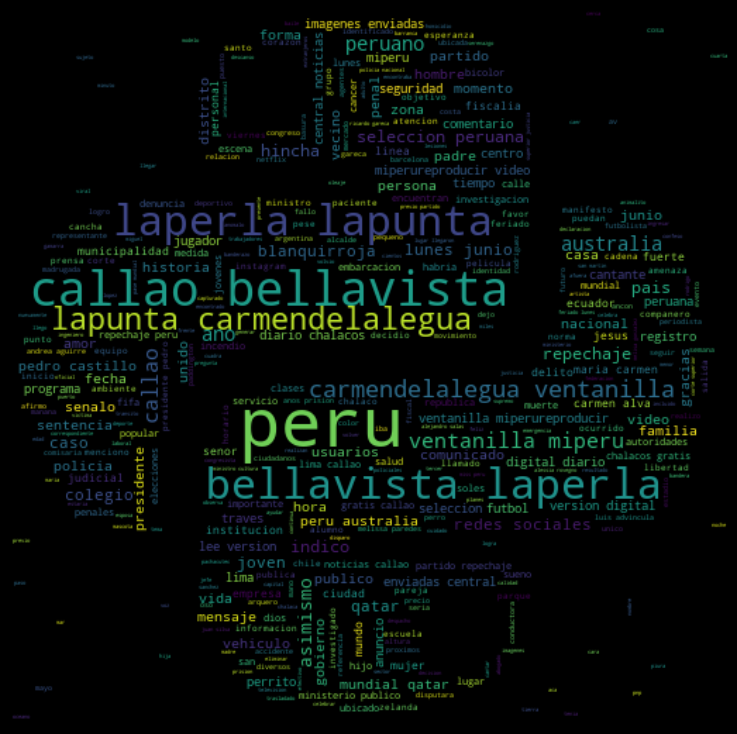

In [332]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

mask = np.array(Image.open("Python.jpg"))
mask[mask == 1] = 255

text = ' '.join(tokens_tuned)
wordcloud = WordCloud(width = 3000,height=2000, max_words=1000, background_color='black', mask=mask).generate(text)
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### Modelo Estadístico N-Gram - Comementarios

In [754]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('reuters')

In [755]:
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten

In [756]:
try: # Use the default NLTK tokenizer.
    from nltk import word_tokenize, sent_tokenize 
    # Testing whether it works. 
    # Sometimes it doesn't work on some machines because of setup issues.
    word_tokenize(sent_tokenize("This is a foobar sentence. Yes it is.")[0])
except: # Use a naive sentence tokenizer and toktok.
    import re
    from nltk.tokenize import ToktokTokenizer
    # See https://stackoverflow.com/a/25736515/610569
    sent_tokenize = lambda x: re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', x)
    # Use the toktok tokenizer that requires no dependencies.
    toktok = ToktokTokenizer()
    word_tokenize = word_tokenize = toktok.tokenize

In [757]:
text_all = ''.join(dataframe.body_tuned)

In [758]:
import unicodedata
# para normalizar el texto a unicode utilice lo siguiente, omitir tildes y otros
text_norm = unicodedata.normalize('NFKD', text_all).encode('ascii', 'ignore').decode('ascii').lower()

bad_chars = ['#', ',','!', '"', ':', '%', '(',')','...',"'"]

for i in bad_chars :
    text_norm = text_norm.replace(i, '')

In [759]:
print(text_norm[:282])

compania de bombero recibio donaciones de la corte superior de justicia del callao la corte superior de justicia del callao dono un total de 30 bienes entre equipos de sonido accesorios frazadas cuadros lectoras de cd balon de oxigeno y otros a la compania de bomberos peru-18. asim


In [760]:
# Tokenize the text.
tokenized_text = [word_tokenize(s.replace('.','')) for s in sent_tokenize(text_norm)]
print(tokenized_text[0])

['compania', 'de', 'bombero', 'recibio', 'donaciones', 'de', 'la', 'corte', 'superior', 'de', 'justicia', 'del', 'callao', 'la', 'corte', 'superior', 'de', 'justicia', 'del', 'callao', 'dono', 'un', 'total', 'de', '30', 'bienes', 'entre', 'equipos', 'de', 'sonido', 'accesorios', 'frazadas', 'cuadros', 'lectoras', 'de', 'cd', 'balon', 'de', 'oxigeno', 'y', 'otros', 'a', 'la', 'compania', 'de', 'bomberos', 'peru-18']


In [761]:
freq_tokens = FreqDist(word_tokenize(''.join(([' '.join(s) for s in tokenized_text]))))
freq_tokens.most_common(10)

[('de', 983),
 ('la', 596),
 ('el', 529),
 ('a', 469),
 ('que', 469),
 ('en', 431),
 ('y', 319),
 ('del', 291),
 ('se', 228),
 ('por', 185)]

In [762]:
from nltk import bigrams, trigrams
from collections import Counter, defaultdict

# Create a placeholder for model
model = defaultdict(lambda: defaultdict(lambda: 0))

# Count frequency of co-occurance  

sentences = [s.replace('.','') for s in sent_tokenize(text_norm)]
for sentence in sentences:
    for w1, w2, w3 in trigrams(word_tokenize(sentence), pad_right=True, pad_left=True):
        model[(w1, w2)][w3] += 1

for w1_w2 in model:
    total_count = float(sum(model[w1_w2].values()))
    for w3 in model[w1_w2]:
        model[w1_w2][w3] /= total_count

In [763]:
list(trigrams(word_tokenize(sentences[0]), pad_right=True, pad_left=True))

[(None, None, 'compania'),
 (None, 'compania', 'de'),
 ('compania', 'de', 'bombero'),
 ('de', 'bombero', 'recibio'),
 ('bombero', 'recibio', 'donaciones'),
 ('recibio', 'donaciones', 'de'),
 ('donaciones', 'de', 'la'),
 ('de', 'la', 'corte'),
 ('la', 'corte', 'superior'),
 ('corte', 'superior', 'de'),
 ('superior', 'de', 'justicia'),
 ('de', 'justicia', 'del'),
 ('justicia', 'del', 'callao'),
 ('del', 'callao', 'la'),
 ('callao', 'la', 'corte'),
 ('la', 'corte', 'superior'),
 ('corte', 'superior', 'de'),
 ('superior', 'de', 'justicia'),
 ('de', 'justicia', 'del'),
 ('justicia', 'del', 'callao'),
 ('del', 'callao', 'dono'),
 ('callao', 'dono', 'un'),
 ('dono', 'un', 'total'),
 ('un', 'total', 'de'),
 ('total', 'de', '30'),
 ('de', '30', 'bienes'),
 ('30', 'bienes', 'entre'),
 ('bienes', 'entre', 'equipos'),
 ('entre', 'equipos', 'de'),
 ('equipos', 'de', 'sonido'),
 ('de', 'sonido', 'accesorios'),
 ('sonido', 'accesorios', 'frazadas'),
 ('accesorios', 'frazadas', 'cuadros'),
 ('frazadas

In [764]:
# dict(model['de','la'])   

In [765]:
import random

for i in range(5):  
    # starting words
    text = ['del', 'callao']
    sentence_finished = False
    
    while not sentence_finished:
        # select a random probability threshold  
        r = random.random()
        accumulator = .0
        for word in model[tuple(text[-2:])].keys():
            accumulator += model[tuple(text[-2:])][word]
            # select words that are above the probability threshold
            if accumulator >= r:
                text.append(word)
                break

        if text[-2:] == [None, None]:
            sentence_finished = True
    print('')
    print ('Sentence N° '+str(i+1)+' :\n' +' '.join([t for t in text if t]))


Sentence N° 1 :
del callao estan a favor de la 100 p m cuando los internos burlaron la seguridad del estadio ahmed bin alien de qatar 2022 sin duda nuestra gastronomia es una medida mas con la hipotesis del ministerio publico implica que por desgracia no han aprendido a afinar su voz ni tienen tecnica vocal

Sentence N° 2 :
del callao inicio investigacion preventiva contra jonathan garcia 30 alias galgo y anthony pastor 22 alias prins por la muerte de 37 ovinos y otros durante las manifestaciones de noviembre de 2020 y enero de 2021 cuando la adolescente acudia a visitar a su vehiculo presentaban orificios por impacto de bala por lo cual lo hizo huir de la seleccion peruana gianluca lapadula llego a la opinion publica que perdio al bebe que estaban esperando en esa linea los proveedores han mencionado que el lunes 13 a traves de sus manos por la seguridad del estadio y cuando ya estaban a punto de retirarlo el chalaco yoshimar yotun tuvo un gran gesto y le hicieron una broma la cual f

## 4.- Conclusones

1. La resolución del examen se realizó en un entrno de trabajo de **JupyterLab** de **Python 3.7**.
2. Se realizó la obtención de información mediante las técnicas de *scraping* a la pagina de Facebook :  https://www.facebook.com/prensachalaca , haciendo uso de libreías **Selenium** y **BeautifulSoup**.
3. Para el trabajo de forma local en **JupyterLab**, es necesario descargar el driver de goggle : **chromedriver.exe** , para poder concetarse con credenciales de **usuario**, **password** y **página** (web para escrapear).
4. Para facilitar los trabajos de obtención de infoprmación, preliminarmente se escrapearon los *links* de acceso de cada uno de los *post* , mediante la ejecuación de rutinas de *scrolling*de *BeautifulSoup* (autoamtización de la barra de desplazamiento), para ejecutar ello, es necesario tener una buena conexion de internet. 
5. Ls inciales **"web"**, fueron cambiados por **"mobile"**, para facilitar la extracción de información de cada unos de los *post* en la version mobil. Luego, con una rutina de ejecucicón se accede a cada uno de los *post* en la version mobil y extrae la información.
6. El preprocesamiento del texto se realizó, haciendo uso de las libreias **nltk**, **re**, **spacy**, **unicodedata** y **wordcloud**
7. Se obtuvieron una nuve de pabras con la silueta de Python para los datos de **Comentarios del post** y **Cuerpo del publicación post**
8. Se normalizaron los texto (reemplazo de tíldes y conversión a minúsculas)
9. Se realizaron la tecnicas de Tokenización para los datos de **Comentarios del post** donde las 5 primeras palabras con mayor frecuencias fueron : gente, vida, gracias, persona y mujer.
10. Se realizaron la tecnicas de Tokenización para los datos de **Cuerpo del publicación post** donde las 5 primeras palabras con mayor frecuencias fueron : callao, peru, ventanilla, bellavista y laperla.
11. se realizó construcción del Modelo Estadístico N-Gram para **Comentarios del post**, con resultados satifactorios. Se utilizaron como imput las siguientas pablas : **['del', 'peru', 'lo']** y se obtuvieron las siguientes oraciones :

    Sentence N° 1 :
    *del peru lo maximo que podia pasar era un empate eso era supuestamentuque tenias que decir a la familia y si le hubiera ensenado billetes seguro que al final no n nada por mi mediatenorcomediatenorco de*

    Sentence N° 2 :
    *del peru lo maximo chicos vamos con todo el peru y de esto tkm hijo jeferson siempre estaras presente en mi callao querido donde esta el callao hay gente honrada y trabajadora que quiere tomar el mando de todas*

    Sentence N° 3 :
    *del peru lo maximo chicos vamos con fe otras personas tienen loros que son las mas que diassufren por la maldcion la verdadera es de su casa de*
    
    Sentence N° 4 :
    *del peru lo maximo chicos vamos con todo y de jornada semanal*
    
    Sentence N° 5 :
    *del peru lo maximo que podia pasar era un empate eso era supuestamentuque tenias que decir por sacar plata pobre gallito de*
    
12. se realizó construcción del Modelo Estadístico N-Gram para **Cuerpo del publicación post** con resultados satifactorios. Se utilizaron como imput las siguientas pablas : **['del', 'callao']** y se obtuvieron las siguientes oraciones :

    Sentence N° 1 :
    *del callao estan a favor de la 100 p m cuando los internos burlaron la seguridad del estadio ahmed bin alien de qatar 2022 sin duda nuestra gastronomia es una medida mas con la hipotesis del ministerio publico implica que por desgracia no han aprendido a afinar su voz ni tienen tecnica vocal*
    
    Sentence N° 2 :
    *del callao inicio investigacion preventiva contra jonathan garcia 30 alias galgo y anthony pastor 22 alias prins por la muerte de 37 ovinos y otros durante las manifestaciones de noviembre de 2020 y enero de 2021 cuando la adolescente acudia a visitar a su vehiculo presentaban orificios por impacto de bala por lo cual lo hizo huir de la seleccion peruana gianluca lapadula llego a la opinion publica que perdio al bebe que estaban esperando en esa linea los proveedores han mencionado que el lunes 13 a traves de sus manos por la seguridad del estadio y cuando ya estaban a punto de retirarlo el chalaco yoshimar yotun tuvo un gran gesto y le hicieron una broma la cual fue emitida el ultimo y es que la empresa - en construccion hemos logrado que en 1958 se publico el presidente pedro castillo siendo invitado a la bicolorhincha peruano prefirio viajar a qatar 2022 por el asesinato de solsiret rodriguez producto del descenso de las peores entrevistadoras del pais un jefe del estado sea investigado durante su programacion para anunciar que el oso paddington es un pais bastante fuerte en deportes*
    
    Sentence N° 3 :
    *del callao estan a favor de que se encontraba disputando un partido de repechaje que afrontara la seleccion peruana por 4-5 en penales a manos de australia quien hizo unos particulares movimientos en los exteriores del aeropuerto desde muy temprano de igual manera el deportista agradecio las muestras de carino*
    
    Sentence N° 4 :
    *del callao en temas de capacitaciones presenciales y digitales a traves de un familiar*
    
    Sentence N° 5 :
    *del callao plantea suspension parcial en el jiron antonio bazo 171 ; hasta el medio dia este lunes 13 de junio segun el instituto nacional de defensa civil durante el partido decisivo contra australia - forma parte de la misma forma como lo hizo huir de la municipalidad de ventanilla personal del serenazgo de ventanilla personal del serenazgo de ventanilla*
